In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [146]:
pd.set_option('display.max_colwidth', None)

# Przygotowanie danych

In [147]:
data_path = "../../data/4_tanks/data/"

In [148]:
# # dane bez zakłóceń
# df_train = pd.read_csv(data_path+"result_ol_without_noise_uczące_v3.csv", sep=';', index_col=0)
# df_val = pd.read_csv(data_path+"result_ol_without_noise_walidacyjne_v3.csv", sep=';', index_col=0)
# df_test = pd.read_csv(data_path+"result_ol_without_noise_testowe_v3.csv", sep=';', index_col=0)
# dataset_name = "bez zakłóceń"

In [149]:
# dane z zakłóceniami
df_train = pd.read_csv(data_path+"result_ol_with_noise_uczące_v3.csv", sep=';', index_col=0)
df_val = pd.read_csv(data_path+"result_ol_with_noise_walidacyjne_v3.csv", sep=';', index_col=0)
df_test = pd.read_csv(data_path+"result_ol_with_noise_testowe_v3.csv", sep=';', index_col=0)
dataset_name = "z zakłóceniami"

In [150]:
df_train.head()

,q_A [cm^3/s],q_B [cm^3/s],q_d1 [cm^3/s],q_d2 [cm^3/s],q_d3 [cm^3/s],q_d4 [cm^3/s],x1 [cm],x2 [cm],x3 [cm],x4 [cm]
0,452.78,555.56,0.3528,0.3187,0.4085,0.2834,65.000000,66.000000,65.000000,66.000000
1,452.78,555.56,0.0800,0.1137,-0.1839,0.0887,65.337126,66.256004,65.446698,66.276039
2,452.78,555.56,0.1957,-0.0229,0.0229,-0.0154,65.400184,66.300511,65.282069,66.346327
3,452.78,555.56,0.4482,0.0503,-0.0275,-0.2183,65.568204,66.208181,65.331208,66.309705
4,452.78,555.56,0.3735,-0.2422,0.2731,-0.0875,65.980764,66.193910,65.327866,66.071647


In [151]:
def transform_column_name(df):
    df.columns = [col[0] for col in df.columns.str.split()]
    return df

In [152]:
df_train = transform_column_name(df_train)
df_val = transform_column_name(df_val)
df_test = transform_column_name(df_test)

In [153]:
qa_max = round(3260000/3600, 2)
qa_min=0
qb_max = round(4000000/3600)
qb_min=0
x_max = 136
x_min = 20

In [154]:
def min_max_scale(s, min_value, max_value):
    return (s-min_value)/(max_value - min_value)

In [155]:
def min_max_scale_df(df):
    df['q_A'] = min_max_scale(df['q_A'], qa_min, qa_max)
    df['q_B'] = min_max_scale(df['q_B'], qb_min, qb_max)
    df['x1'] = min_max_scale(df['x1'], x_min, x_max)
    df['x2'] = min_max_scale(df['x2'], x_min, x_max)
    df['x3'] = min_max_scale(df['x3'], x_min, x_max)
    df['x4'] = min_max_scale(df['x4'], x_min, x_max)
    return df

In [156]:
# df_train = min_max_scale_df(df_train)
# df_val = min_max_scale_df(df_val)
# df_test = min_max_scale_df(df_test)

In [157]:
def add_delay(df, col, steps=1):    
    df[col+f'(k-{steps})'] = df[col].shift(steps)
    return df

In [158]:
cols_delay = ['q_A', 'q_B', 'x1', 'x2', 'x3', 'x4']
for col in cols_delay:
    df_train = add_delay(df_train, col, 1)
    df_val = add_delay(df_val, col, 1)
    df_test = add_delay(df_test, col, 1)
    df_train = add_delay(df_train, col, 2)
    df_val = add_delay(df_val, col, 2)
    df_test = add_delay(df_test, col, 2)

In [159]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

In [160]:
print(f"Wymiar danych uczących: {df_train.shape}")
print(f"Wymiar danych walidacyjnych: {df_val.shape}")
print(f"Wymiar danych testowych: {df_test.shape}")

Wymiar danych uczących: (2998, 22)
Wymiar danych walidacyjnych: (998, 22)
Wymiar danych testowych: (998, 22)


# Regresja liniowa

In [161]:
model_type = "regresji liniowej"

In [162]:
y_names = ['x1', 'x2', 'x3', 'x4']

In [163]:
lr_type_dict = {'statespace': 'w przestrzeni stanu', 'io': 'wejście-wyjście'}

In [164]:
pred_recursion = False
pred_mode = 'bez rekurencji'
# pred_recursion = True
# pred_mode = 'z rekurencją'

In [165]:
def calc_RMSE(df_train, df_val, df_test, y_name, y_pred_name):
    RMSE_train = round(metrics.root_mean_squared_error(df_train[y_name], df_train[y_pred_name]), 4)
    RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[y_pred_name]), 4)
    RMSE_test = round(metrics.root_mean_squared_error(df_test[y_name], df_test[y_pred_name]), 4)

    return RMSE_train, RMSE_val, RMSE_test

In [166]:
def predict_recursion(df, model, features, y_name, order_dyn):
    y_pred_list = np.empty(len(df))
    start_idx = 0
    if order_dyn == 1:
        y_pred_list[0] = df[y_name].iloc[0]
        start_idx = 1
    elif order_dyn==2:
        y_pred_list[0] = df[y_name].iloc[0]
        y_pred_list[1] = df[y_name].iloc[1]
        start_idx = 2
    for i in range(start_idx, len(df)):
        features_val = df[features].iloc[i].copy()
        # print(f'features_val:\n{features_val}')
        if order_dyn == 1:
            features_val[f'{y_name}(k-1)'] = y_pred_list[i-1]
        if order_dyn == 2:
            features_val[f'{y_name}(k-1)'] = y_pred_list[i-1]
            features_val[f'{y_name}(k-2)'] = y_pred_list[i-2]
        # print(f'features_val:\n{features_val}')
        y_pred_list[i] = model.predict(pd.DataFrame(features_val).T)
        # print(f'y_pred: {y_pred_list[i]}')
    return y_pred_list

In [167]:
def train_predict_lin_model(df_train, df_val, df_test, y_names, feature_list, lr_type, order_dyn, pred_recursion=False):
    
    models_results_df = pd.DataFrame(columns=["Typ modelu", "Zmienne wejściowe", "Zmienna wyjściowa", "Współczynniki modelu", "RMSE_ucz", "RMSE_wal", "RMSE_test"])

    for y_name, features in zip(y_names, feature_list):

        model = LinearRegression()
        model.fit(df_train[features], df_train[y_name])

        if pred_recursion:
            df_train[f'{y_name}_{lr_type}_{order_dyn}_pred'] = predict_recursion(df_train, model, features, y_name, order_dyn)
            df_val[f'{y_name}_{lr_type}_{order_dyn}_pred'] = predict_recursion(df_val, model, features, y_name, order_dyn)
            df_test[f'{y_name}_{lr_type}_{order_dyn}_pred'] = predict_recursion(df_test, model, features, y_name, order_dyn)
        else:
            df_train[f'{y_name}_{lr_type}_{order_dyn}_pred'] = model.predict(df_train[features])
            df_val[f'{y_name}_{lr_type}_{order_dyn}_pred'] = model.predict(df_val[features])
            df_test[f'{y_name}_{lr_type}_{order_dyn}_pred'] = model.predict(df_test[features])
        
        df_train[f'e_{y_name}_{lr_type}_{order_dyn}'] = df_train[y_name] - df_train[f'{y_name}_{lr_type}_{order_dyn}_pred']
        df_val[f'e_{y_name}_{lr_type}_{order_dyn}'] = df_val[y_name] - df_val[f'{y_name}_{lr_type}_{order_dyn}_pred']
        df_test[f'e_{y_name}_{lr_type}_{order_dyn}'] = df_test[y_name] - df_test[f'{y_name}_{lr_type}_{order_dyn}_pred']
        RMSE_train, RMSE_val, RMSE_test = calc_RMSE(df_train, df_val, df_test, y_name, f'{y_name}_{lr_type}_{order_dyn}_pred')
        
        lr_type_str = lr_type_dict[lr_type]
        models_results_df.loc[len(models_results_df)] = [lr_type_str, features, y_name+'(k)', np.round(model.coef_, 3), RMSE_train, RMSE_val, RMSE_test]

    return df_train, df_val, df_test, models_results_df

In [168]:
models_results_df = pd.DataFrame(columns=["Typ modelu", "Zmienne wejściowe", "Zmienna wyjściowa", "Współczynniki modelu"])


In [169]:
y_names = ['x1', 'x2', 'x3', 'x4']

In [170]:
if not pred_recursion:
    features_list = [['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)'],
                    ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)'],
                    ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)'],
                    ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)']]
    lr_type = 'statespace'
    order_dyn = 0
    df_train, df_val, df_test, models_results_df_state_space_0 = train_predict_lin_model(df_train, df_val, df_test, y_names, features_list, lr_type, order_dyn)
    models_results_df = pd.concat([models_results_df, models_results_df_state_space_0])

In [171]:
features_list = [['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x1(k-1)'],
                 ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)', 'x2(k-1)'],
                 ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)', 'x3(k-1)'],
                 ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)']]
lr_type = 'statespace'
order_dyn = 1
df_train, df_val, df_test, models_results_df_state_space_1 = train_predict_lin_model(df_train, df_val, df_test, y_names, features_list, lr_type, order_dyn, pred_recursion)
models_results_df = pd.concat([models_results_df, models_results_df_state_space_1])

In [172]:
features_list = [['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x1(k-1)', 'x1(k-2)'],
                 ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)', 'x2(k-1)', 'x2(k-2)'],
                 ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)', 'x3(k-1)', 'x3(k-2)'],
                 ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x4(k-2)']]
lr_type = 'statespace'
order_dyn = 2
df_train, df_val, df_test, models_results_df_io_2 = train_predict_lin_model(df_train, df_val, df_test, y_names, features_list, lr_type, order_dyn, pred_recursion)
models_results_df = pd.concat([models_results_df, models_results_df_io_2])

In [173]:
features_list = [['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)'],
 ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)'],
 ['q_A(k-1)', 'q_B(k-1)', 'x3(k-1)'],
 ['q_A(k-1)', 'q_B(k-1)', 'x4(k-1)']]
lr_type = 'io'
order_dyn = 1
df_train, df_val, df_test, models_results_df_io_1 = train_predict_lin_model(df_train, df_val, df_test, y_names, features_list, lr_type, order_dyn, pred_recursion)
models_results_df = pd.concat([models_results_df, models_results_df_io_1])

In [174]:
features_list = [['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x1(k-2)'],
 ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x2(k-2)'],
 ['q_A(k-1)', 'q_B(k-1)', 'x3(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x3(k-2)'],
 ['q_A(k-1)', 'q_B(k-1)', 'x4(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x4(k-2)']]
lr_type = 'io'
order_dyn = 2
df_train, df_val, df_test, models_results_df_io_2 = train_predict_lin_model(df_train, df_val, df_test, y_names, features_list, lr_type, order_dyn, pred_recursion)
models_results_df = pd.concat([models_results_df, models_results_df_io_2])

In [175]:
def get_result_per_output(y_name, models_results_df):
    models_results_df1 = models_results_df[models_results_df["Zmienna wyjściowa"]==f'{y_name}(k)']
    models_results_df1.index = np.arange(1, len(models_results_df1)+1)
    return models_results_df1

In [176]:
models_results_df.rename(columns={'RMSE_ucz': '$RMSE_{ucz}$', 'RMSE_wal': '$RMSE_{wal}$', 'RMSE_test': '$RMSE_{test}$'}, inplace=True)

In [177]:
models_results_df_x1 = get_result_per_output('x1', models_results_df)
models_results_df_x2 = get_result_per_output('x2', models_results_df)
models_results_df_x3 = get_result_per_output('x3', models_results_df)
models_results_df_x4 = get_result_per_output('x4', models_results_df)

In [178]:
models_results_df_x3[['Typ modelu', 'Zmienne wejściowe', 'Zmienna wyjściowa', 
       '$RMSE_{ucz}$', '$RMSE_{wal}$', '$RMSE_{test}$', 'Współczynniki modelu']]

,Typ modelu,Zmienne wejściowe,Zmienna wyjściowa,$RMSE_{ucz}$,$RMSE_{wal}$,$RMSE_{test}$,Współczynniki modelu
1,w przestrzeni stanu,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x4(k-1)]",x3(k),11.9669,10.2135,5.5555,"[-0.041, 0.042, 0.925, 0.431, -0.268]"
2,w przestrzeni stanu,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x4(k-1), x3(k-1)]",x3(k),0.3310,0.6293,0.3035,"[0.0, 0.007, -0.04, -0.02, 0.019, 1.011]"
3,w przestrzeni stanu,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x4(k-1), x3(k-1), x3(k-2)]",x3(k),0.2961,0.4658,0.2678,"[0.0, 0.004, -0.022, -0.014, 0.012, 1.419, -0.413]"
4,wejście-wyjście,"[q_A(k-1), q_B(k-1), x3(k-1)]",x3(k),0.5581,0.6685,0.3344,"[0.0, 0.006, 0.979]"
5,wejście-wyjście,"[q_A(k-1), q_B(k-1), x3(k-1), q_A(k-2), q_B(k-2), x3(k-2)]",x3(k),0.2704,0.2916,0.2464,"[-0.0, 0.01, 1.832, 0.0, -0.009, -0.834]"


In [179]:
print(models_results_df_x1[['Typ modelu', 'Zmienne wejściowe', 'Zmienna wyjściowa', 
       '$RMSE_{ucz}$', '$RMSE_{wal}$', '$RMSE_{test}$']].to_latex(float_format="%.4f", caption=f'Wyniki modelowania poziomu w 1. zbiorniku {pred_mode} dla {model_type} dla danych {dataset_name}.', label=f'tab:res_{model_type}_{dataset_name}_{pred_mode}_x1'))

\begin{table}
\caption{Wyniki modelowania poziomu w 1. zbiorniku bez rekurencji dla regresji liniowej dla danych z zakłóceniami.}
\label{tab:res_regresji liniowej_z zakłóceniami_bez rekurencji_x1}
\begin{tabular}{llllrrr}
\toprule
 & Typ modelu & Zmienne wejściowe & Zmienna wyjściowa & $RMSE_{ucz}$ & $RMSE_{wal}$ & $RMSE_{test}$ \\
\midrule
1 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)'] & x1(k) & 8.7244 & 8.2046 & 4.1687 \\
2 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x1(k-1)'] & x1(k) & 0.2858 & 0.3342 & 0.2310 \\
3 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x1(k-1)', 'x1(k-2)'] & x1(k) & 0.2492 & 0.2656 & 0.2324 \\
4 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)'] & x1(k) & 0.3451 & 0.4249 & 0.2417 \\
5 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x1(k-2)'] & x1(k) & 0.2520 & 0.2746 & 0.2437 \\
\bottomrule
\end{tabular}
\end{

In [180]:
print(models_results_df_x2[['Typ modelu', 'Zmienne wejściowe', 'Zmienna wyjściowa', 
       '$RMSE_{ucz}$', '$RMSE_{wal}$', '$RMSE_{test}$']].to_latex(float_format="%.4f", caption=f'Wyniki modelowania poziomu w 2. zbiorniku {pred_mode} dla {model_type} dla danych {dataset_name}.', label=f'tab:res_{model_type}_{dataset_name}_{pred_mode}_x2'))

\begin{table}
\caption{Wyniki modelowania poziomu w 2. zbiorniku bez rekurencji dla regresji liniowej dla danych z zakłóceniami.}
\label{tab:res_regresji liniowej_z zakłóceniami_bez rekurencji_x2}
\begin{tabular}{llllrrr}
\toprule
 & Typ modelu & Zmienne wejściowe & Zmienna wyjściowa & $RMSE_{ucz}$ & $RMSE_{wal}$ & $RMSE_{test}$ \\
\midrule
1 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)'] & x2(k) & 5.7016 & 7.1621 & 4.9003 \\
2 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)', 'x2(k-1)'] & x2(k) & 0.2883 & 0.5499 & 0.2651 \\
3 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)', 'x2(k-1)', 'x2(k-2)'] & x2(k) & 0.2603 & 0.4069 & 0.2483 \\
4 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)'] & x2(k) & 0.4272 & 0.4290 & 0.2834 \\
5 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x2(k-2)'] & x2(k) & 0.2698 & 0.2669 & 0.2546 \\
\bottomrule
\end{tabular}
\end{

In [181]:
print(models_results_df_x3[['Typ modelu', 'Zmienne wejściowe', 'Zmienna wyjściowa', 
       '$RMSE_{ucz}$', '$RMSE_{wal}$', '$RMSE_{test}$']].to_latex(float_format="%.4f", caption=f'Wyniki modelowania poziomu w 3. zbiorniku {pred_mode} dla {model_type} dla danych {dataset_name}.', label=f'tab:res_{model_type}_{dataset_name}_{pred_mode}_x3'))

\begin{table}
\caption{Wyniki modelowania poziomu w 3. zbiorniku bez rekurencji dla regresji liniowej dla danych z zakłóceniami.}
\label{tab:res_regresji liniowej_z zakłóceniami_bez rekurencji_x3}
\begin{tabular}{llllrrr}
\toprule
 & Typ modelu & Zmienne wejściowe & Zmienna wyjściowa & $RMSE_{ucz}$ & $RMSE_{wal}$ & $RMSE_{test}$ \\
\midrule
1 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)'] & x3(k) & 11.9669 & 10.2135 & 5.5555 \\
2 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)', 'x3(k-1)'] & x3(k) & 0.3310 & 0.6293 & 0.3035 \\
3 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)', 'x3(k-1)', 'x3(k-2)'] & x3(k) & 0.2961 & 0.4658 & 0.2678 \\
4 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x3(k-1)'] & x3(k) & 0.5581 & 0.6685 & 0.3344 \\
5 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x3(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x3(k-2)'] & x3(k) & 0.2704 & 0.2916 & 0.2464 \\
\bottomrule
\end{tabular}
\en

In [182]:
print(models_results_df_x4[['Typ modelu', 'Zmienne wejściowe', 'Zmienna wyjściowa', 
       '$RMSE_{ucz}$', '$RMSE_{wal}$', '$RMSE_{test}$']].to_latex(float_format="%.4f", caption=f'Wyniki modelowania poziomu w 4. zbiorniku {pred_mode} dla {model_type} dla danych {dataset_name}.', label=f'tab:res_{model_type}_{dataset_name}_{pred_mode}_x4'))

\begin{table}
\caption{Wyniki modelowania poziomu w 4. zbiorniku bez rekurencji dla regresji liniowej dla danych z zakłóceniami.}
\label{tab:res_regresji liniowej_z zakłóceniami_bez rekurencji_x4}
\begin{tabular}{llllrrr}
\toprule
 & Typ modelu & Zmienne wejściowe & Zmienna wyjściowa & $RMSE_{ucz}$ & $RMSE_{wal}$ & $RMSE_{test}$ \\
\midrule
1 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)'] & x4(k) & 10.0591 & 13.0976 & 10.7349 \\
2 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)'] & x4(k) & 0.4116 & 0.3516 & 0.2950 \\
3 & w przestrzeni stanu & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x4(k-2)'] & x4(k) & 0.3175 & 0.2936 & 0.2666 \\
4 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x4(k-1)'] & x4(k) & 0.4880 & 0.4653 & 0.4220 \\
5 & wejście-wyjście & ['q_A(k-1)', 'q_B(k-1)', 'x4(k-1)', 'q_A(k-2)', 'q_B(k-2)', 'x4(k-2)'] & x4(k) & 0.2753 & 0.2674 & 0.2710 \\
\bottomrule
\end{tabular}
\e

In [183]:
# y_name_pred_split = y_name_pred.split('_')
# model_type = y_name_pred_split[1]
# order_dyn = y_name_pred_split[2]
# lr_type_dict[model_type]

In [184]:
def plot_model_result(df, y_name, pred_mode):
    plt.grid()
    plt.plot(df[y_name], label='Rzeczywisty', linewidth=3.5)
    y_names_pred = [col for col in df.columns if (y_name in col) & ('pred' in col)]
    colors = ['tab:olive', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan', 'tab:gray']
    color_i=0
    if pred_mode=='z rekurencją':
        color_i=1
    for i, y_name_pred, c in zip(np.arange(1, len(y_names_pred)+1), y_names_pred, colors[color_i:len(y_names_pred)+color_i]):
        plt.plot(df[y_name_pred], label=f'Model {i}', linewidth=(3.5-(i)*0.5), c=c)
    plt.xlabel('Czas [s]')
    plt.ylabel('Poziom cieczy')
    plt.title(f"Poziom cieczy w {y_name[1]}. zbiorniku")
    plt.legend()

In [185]:
def plot_model_result_all_tanks(df, dataset_name, data_name, pred_mode):
    fig=plt.figure(figsize=(8,11.5))
    plt.subplot(4, 1, 1)
    plot_model_result(df, 'x1', pred_mode)
    plt.subplot(4, 1, 2)
    plot_model_result(df, 'x2', pred_mode)
    plt.subplot(4, 1, 3)
    plot_model_result(df, 'x3', pred_mode)
    plt.subplot(4, 1, 4)
    plot_model_result(df, 'x4', pred_mode)

    plt.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"Wyniki {pred_mode} modeli liniowych dla danych {data_name} {dataset_name}")

    plt.savefig(f"../img/result_ol_{model_type}_{data_name}_{dataset_name}_{pred_mode}.png", bbox_inches='tight')

    plt.show()

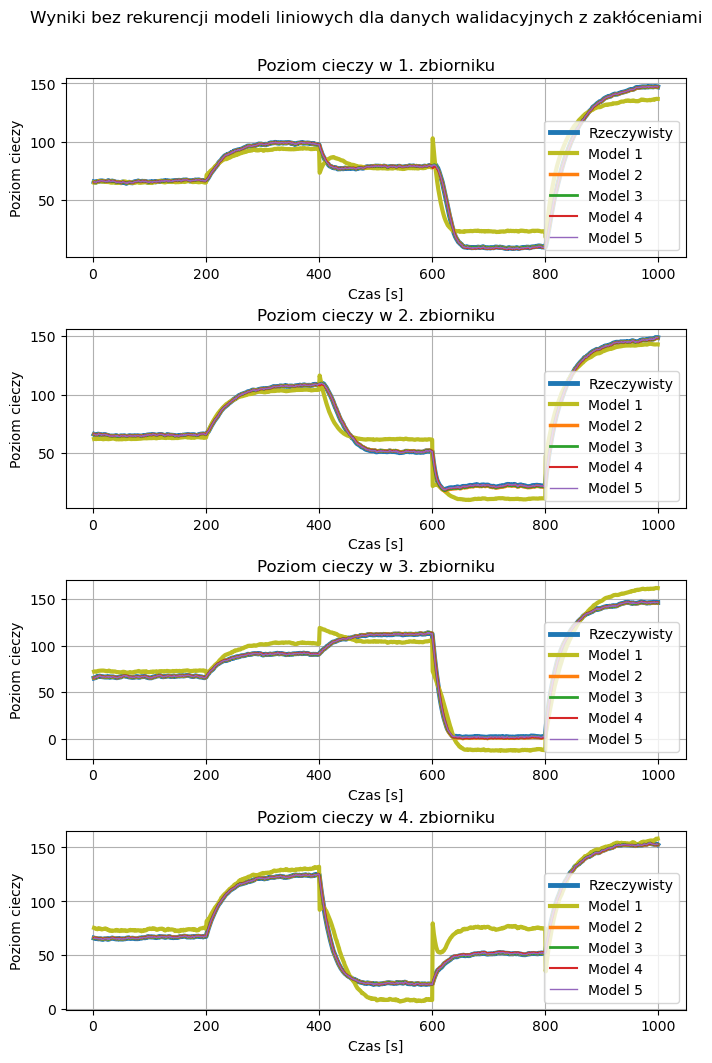

In [186]:
plot_model_result_all_tanks(df_val, dataset_name, "walidacyjnych", pred_mode)

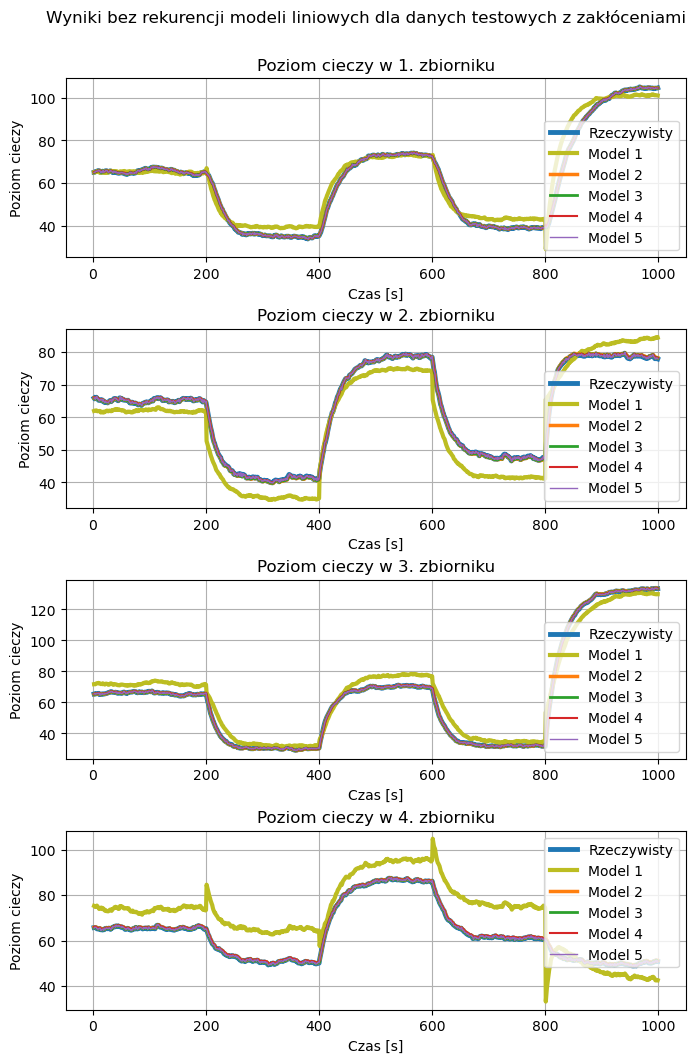

In [187]:
plot_model_result_all_tanks(df_test, dataset_name, "testowych", pred_mode)

In [188]:
def plot_model_error(df, y_name, pred_mode):
    plt.grid()
    e_list = [col for col in df.columns if (y_name in col) & ('e_x' in col)]
    colors = ['tab:olive', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan', 'tab:gray']
    color_i=0
    if pred_mode=='z rekurencją':
        color_i=1
    for i, e, c in zip(np.arange(1, len(e_list)+1), e_list, colors[color_i:len(e_list)+color_i]):
        plt.plot(df[e], label=f'Model {i}', linewidth=(3.5-(i)*0.5), c=c)
    plt.xlabel('Czas [s]')
    plt.ylabel('Błąd')
    plt.title(f"Błędy modeli dla {y_name[1]}. zbiorniku")
    plt.legend()

In [189]:
def plot_model_error_all_tanks(df, dataset_name, data_name, pred_mode):
    fig=plt.figure(figsize=(8,11.5))
    plt.subplot(4, 1, 1)
    plot_model_error(df, 'x1', pred_mode)
    plt.subplot(4, 1, 2)
    plot_model_error(df, 'x2', pred_mode)
    plt.subplot(4, 1, 3)
    plot_model_error(df, 'x3', pred_mode)
    plt.subplot(4, 1, 4)
    plot_model_error(df, 'x4', pred_mode)

    plt.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"Błędy modeli liniowych dla danych {data_name} {dataset_name} w trybie {pred_mode}")

    plt.savefig(f"../img/error_ol_{model_type}_{data_name}_{dataset_name}_v3_{pred_mode}.png", bbox_inches='tight')

    plt.show()

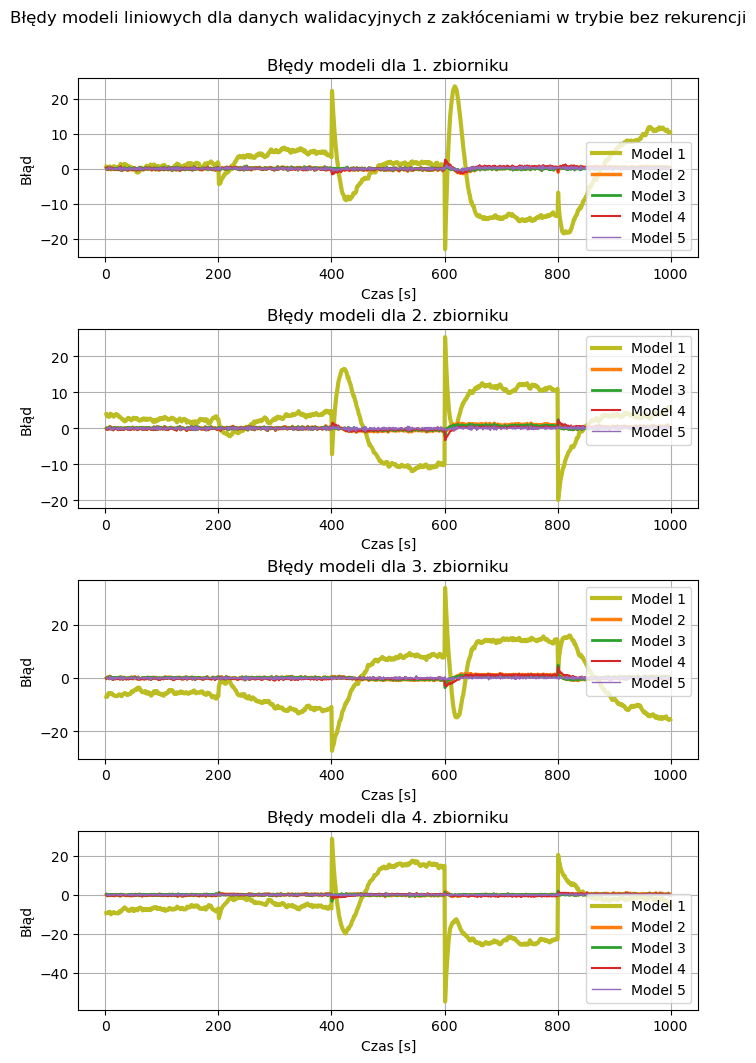

In [190]:
plot_model_error_all_tanks(df_val, dataset_name, "walidacyjnych", pred_mode)

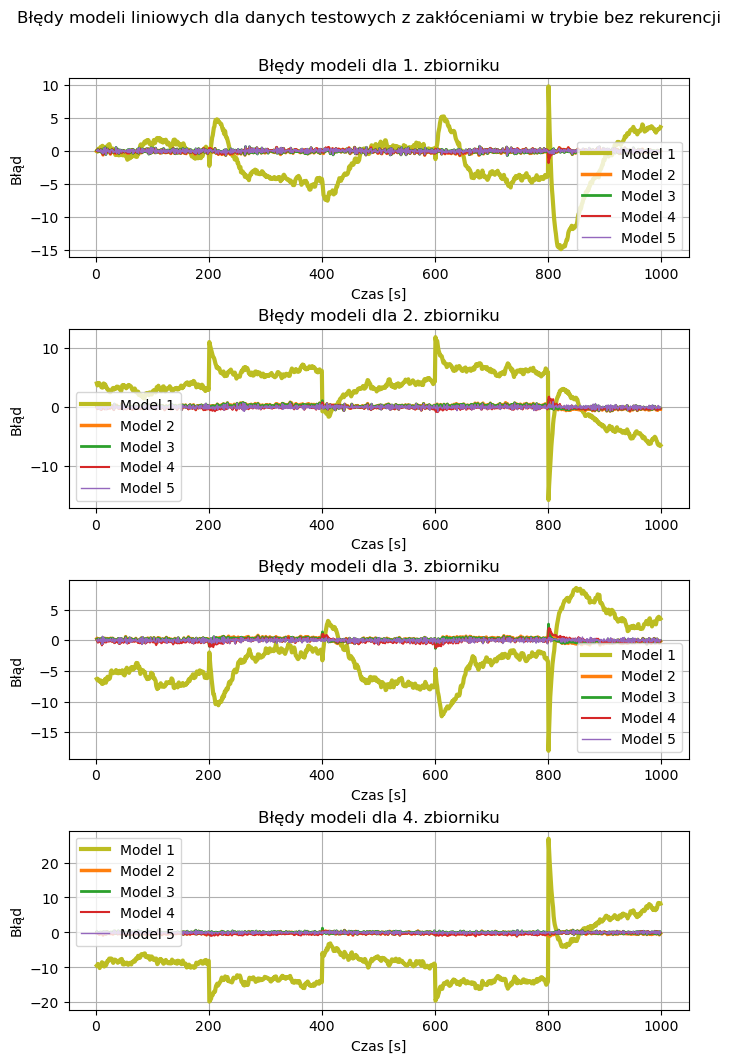

In [191]:
plot_model_error_all_tanks(df_test, dataset_name, "testowych", pred_mode)